# TEDS End-to-End Simulation for TANGO-Carbon

#### This notebook includes a full-chain processing pipeline for TANGO Carbon. The chain is setup for consistent processing that is outlined in the following diagram:  

![title](./tango_e2es_Carbon_chain.png)

After inilialization, eight processing steps are sperated:
1. Initialization
2.

The Processor Assessment Module (PAM) includes default visualization and comparison tools. Feel free to modify the plotting scripts and add your own implementation fitting your specific purpose.

## 1. Reference
+ ATBD
+ User manual <a href="https://teds.rtfd.io/"> online document</a>

## 2. Initialization

#### 2.1 Setup the working environment

In [1]:
import sys
import os
import yaml

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp1_full_chain/")

#### 2.2 import TEDS modules

In [2]:
from teds.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.siml1b import simplified_instrument_model_and_l1b_processor
from teds.l1l2.l1bl2 import level1b_to_level2_processor_RTorCH4, level1b_to_level2_processor
from teds.l2l4 import level2_to_level4_processor          
from teds.pam import pam_co2

#### 2.3 Select the target scene named after the targeted power plant 
Currently, four reference scenes can be used: (1) Matimba, (2) Jenschwalde, (3) Belchatow, (4) Lipetsk.


In [3]:
#station_name = 'Matimba'
station_name = 'Jaenschwalde'
#station_name = 'Belchatow'
#station_name = 'Lipetsk'

### 2.4 Configure specific run
All module interfaces are file-based. So, if input files exist, they cn be called as 'stand-alone'. Note that you might to run low level modules to generate the input. PM modules can be also used as 'stand-alone' for data analysis.

In [4]:
proc_gm     = False; pam_gm     = False
proc_sgmgeo = False; pam_sgmgeo = False
proc_sgmrad = False; pam_sgmrad = False
proc_im     = False; pam_im     = False
proc_l1al1b = False; pam_l1b    = False
proc_siml1b = False  
proc_l1bl2  = False;  pam_l2     = True
proc_l4     = True

## 3. Geometry Model

#### 3.1 Run the GM module

In [5]:
if(proc_gm):
    #configureation file
    gm_config= yaml.safe_load(open('./settings/gm_config_stations.yaml'))
    #select the list for the selected target
    gm_config['orbit'] = gm_config[station_name]['orbit']
    gm_config['sensors'] = gm_config[station_name]['sensors']
    geometry_module(gm_config)

#### 3.2 Visualization of the GM output

For plt_options use 'geoloc' to show the geolocation of the pixel center points, and 'geometry' to show solar zenith angle, viewing zenith angle, solar azimuth angle, and viewing azimuth angle.

In [6]:
if(pam_gm):
    gm_config= yaml.safe_load(open('./settings/gm_config_stations.yaml'))
    filen = gm_config['io_files']['output_gm']
    plt_option = 'geoloc'
    pam_co2.pam_gm_Tango_Carbon(filen, station_name, plt_option)

## 4. Scene Generatior Module (SGM): Geo-Physical Scene

### 4.1 Run the SGM-GEO module

In [7]:
if(proc_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config_stations.yaml'))
    #adjust target specific configs
    sgmgeo_config['io_files']['input_s2'] = sgmgeo_config[station_name]['input_s2']
    sgmgeo_config['io_files']['meteo'] = sgmgeo_config[station_name]['meteo']

    geoscene_generation(sgmgeo_config)

### 4.2 Vizualization of SGM-GPS output

plt_options is used to configure the output. 
* The input 'albedo Bxx' specifies the spectral band to be plotted. Here, xx is the band specification. Only bands can be plotted that are given in the input data (e.g. B08 is not available but the more norrow band B08A can be plotted). 
* The input 'Xxx' specifies the trace gas. Here, xx can be CO2, NO, NO2, CH4, or H2O

In [8]:
if(pam_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config_stations.yaml'))
    filen = sgmgeo_config['io_files']['output_geo']
    plt_option = 'XCO2'
    #plt_option = 'albedo B11'
    pam_co2.pam_sgm_gps(filen, station_name, plt_option)

## 5. Scene Generator Module (SGM): Radiation Scene

### 5.1 Run SGM-RAD module to generate the radiometric scene

In [9]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    Carbon_radiation_scene_generation(sgmrad_config)

### 5.2 PAM Visualization of radiometric scene
Two panels are created. First a map of the radiometric scene for the wavelength wavel. On this map up to four pixels can be chosen using the tuple ialt_iact. The corresponding spectra are dipicted in the right panel.

In [10]:
if(pam_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    filen_rad = sgmrad_config['io_files']['output_rad']
    wavel = 1600.0
    ialt_iact = [[50,50], [100,3], [105,79], [0,1]]
    pam_co2.pam_sgm_rad(filen_rad, station_name, wavel, ialt_iact)

## 6. Instrument Model (IM)

The instrument model uses instrument Calibration Key Data to simulate instrument detector images 

### 6.1 Run the IM

In [11]:
if(proc_im):
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    run_instrument_model(im_config)

### 6.2 PAM Plotting detector images

The generated L0 data contain a series of detector images. The index ialt points to the image.

In [12]:
if(pam_im):
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    filen_rad = im_config['io']['l1a']
    ialt = 50
    title = station_name + f' image no. {ialt}'
    data_max = 10000.
    pam_co2.pam_im(filen_rad, ialt, data_max, title)

## 7. L1A to L1B Processor (PDGS element)

The L1A-L1B processor is a module for the Payload Data Ground Segement. It calibrated the simulated detector images.

### 7.1 Execute L1A-L1B data processing

In [13]:
if(proc_l1al1b):
    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    run_l1al1b(l1al1b_config)

### 7.2 Simplified L1B generator

For some studies, it makes sense to replace the IM and the L1A-L1B processor by a simple L1B generator that simulates a L1B product from the SGM simulations. It applies a spectral convolution and a two-parameter SNR model to the spectra and allocates the GM geolocation to the data product.

In [14]:
if(proc_siml1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    simplified_instrument_model_and_l1b_processor(siml1b_config)

### 7.3 PAM Comparision with SGM-RAD output

_plt_options = spectrum_ requires the input of ialt and iact index to select the spectrum. It compares the processed spectrum with an ISRF-convolved SGM spectrum. Therefore, proper ISRF configuration is needed. 

_plt_options = histo_ gives a histogram of 
$$
\frac{I_{L1b}(\lambda) -I_{ref}(\lambda)}{\sigma(\lambda)}
$$ 
for all spectra. A correct unbiased processing yields a normal distribution with a standard deviation of 1 and a mean of 0.

In [15]:
if(pam_l1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    filen_l1b = siml1b_config['io_files']['output_l1b']
    filen_sgmrad = siml1b_config['io_files']['input_sgm']
    isrf_config={}
    isrf_config['type'] = 'Gaussian'  #type of ISRF, currently only Gaussian or generalized_normal
    isrf_config['fwhm'] = 0.45        #fwhm [nm]
    plt_options = 'spectrum'
    ialt,iact =(50,97)                #onoly needed in case of plt_options = spectrum
    plt_options = 'histo'
    spec_nominal = True               #True means plotting only nominal spectral range [1590-1675]
    pam_co2.pam_l1b(filen_l1b, filen_sgmrad, isrf_config, plt_options, ialt, iact, spec_nominal)

## 8. Level 1B to Level 2 $\rm CO_2$ and $\rm CH_4$ Proxy Retrieval

### 8.1 L2 processing of the $\mathrm{CO_2}$ and $\mathrm{CH_4}$ proxy product

In [16]:
if(proc_l1bl2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    level1b_to_level2_processor_RTorCH4(l1bl2_config)
#    level1b_to_level2_processor(l1bl2_config)

### 8.2 PAM L2 comparision with SGM-GEO reference

_plt_options = 'map'_ creates a map of the retrieved and the true XCO2 for the data granule.
_plt_options = 'histo'_ creates a histogram of all
$$
\mathrm{\frac{XCO_{2}^{ret} -XCO_2^{ref}}{\sigma(XCO_2)}}
$$ 
for all spatial samples. A correct unbiased processing yields a normal distribution with a standard deviation of 1 and a mean of 0.

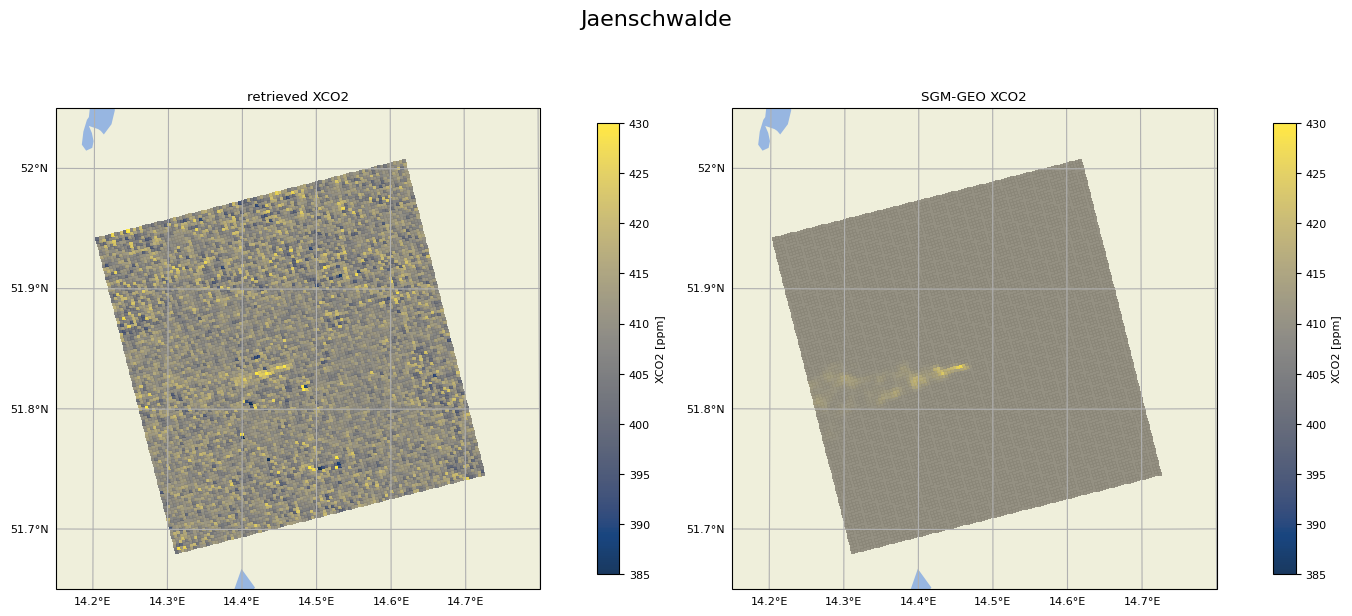

In [17]:
if(pam_l2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    filen = l1bl2_config['io_files']['output_l2']
    filen_ref = sgmrad_config['io_files']['output_geo_ref']
    plt_options ='map'
    vscale = [385, 430]
    pam_co2.pam_l2(filen, filen_ref, station_name, plt_options, vscale)
    

## 9. Level-2 to Level-4 Processing

The processor is a simplified inversion of L2 product to derive emission fluxes assuming perfect knowlegde of the wind field. This tool is usefull to flowdown the lower level mission performance metrics to L4 performance. 

In [18]:
if(proc_l4):
    l2l4_config= yaml.safe_load(open('./settings/l2l4_config.yaml'))
    l4_product=level2_to_level4_processor(l2l4_config)

[18:37:21] Fitted scaling factor (alpha, XCO2 proxy): 733.959 ± 54.012
[18:37:21] Grouped NetCDF file '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level4/Tango_Carbon_l4_exp1.0.nc' created successfully.
[18:37:21] => Level 2 to Level 4 processing finished successfully


Processing with method: microhh_fit
